# Conformity Analysis
Performed for PM2.5 Maintenance area of Pierce County. The plot below shows the geographic extent of the area. This is used to summarize running emissions. Emissions totals are calculated using the same process as regional emissions. 

Pierce County start emissions are scaled based on the VMT in the maintenance area versus VMT for Pierce County.

In [1]:
import os, sys
import geopandas as gpd
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
from shapely import wkt
sys.path.append(os.path.join(os.getcwd(),r'..\..\..'))
from input_configuration import model_year, base_year
sys.path.append(os.path.join(os.getcwd(),r'..\..\..\scripts\summarize\standard'))
from standard_summary_configuration import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
# The set of functions below are used for a variety of calculations. 
# These are adapted from the main emissions.py script used calculate regional emissions

In [3]:
def read_from_sde(connection_string, feature_class_name, version,
                  crs={'init': 'epsg:2285'}, is_table = False):
    """
    Returns the specified feature class as a geodataframe from ElmerGeo.
    
    Parameters
    ----------
    connection_string : SQL connection string that is read by geopandas 
                        read_sql function
    
    feature_class_name: the name of the featureclass in PSRC's ElmerGeo 
                        Geodatabase
    
    cs: cordinate system
    """


    engine = sqlalchemy.create_engine(connection_string)
    con=engine.connect()
    #con.execute("sde.set_current_version {0}".format(version))
    if is_table:
        gdf=pd.read_sql('select * from %s' % 
                   (feature_class_name), con=con)
        con.close()

    else:
        df=pd.read_sql('select *, Shape.STAsText() as geometry from %s' % 
                   (feature_class_name), con=con)
        con.close()

        df['geometry'] = df['geometry'].apply(wkt.loads)
        gdf=gpd.GeoDataFrame(df, geometry='geometry')
        gdf.crs = crs
        cols = [col for col in gdf.columns if col not in 
                ['Shape', 'GDB_GEOMATTR_DATA', 'SDE_STATE_ID']]
        gdf = gdf[cols]
    
    return gdf


def grams_to_tons(value):
    """ Convert grams to tons."""

    value = value/453.592
    value = value/2000

    return value

def calculate_interzonal_vmt(df):
    """ Calcualte inter-zonal running emission rates from network outputs. """

    # List of vehicle types to include in results; note that bus is included here but not for intrazonals
    vehicle_type_list = ['sov','hov2','hov3','bus','medium_truck','heavy_truck']

    # Apply county names
    county_id_lookup = {
        33: 'king',
        35: 'kitsap',
        53: 'pierce',
        61: 'snohomish'
    }

    df['geog_name'] = df['@countyid'].map(county_id_lookup)

    # Remove links with facility type = 0 from the calculation
    df['facility_type'] = df['data3']    # Rename for human readability
    df = df[df['facility_type'] > 0]

    # Calculate VMT by bus, SOV, HOV2, HOV3+, medium truck, heavy truck
    df['sov_vol'] = df['@sov_inc1']+df['@sov_inc2']+df['@sov_inc3']
    df['sov_vmt'] = df['sov_vol']*df['length']
    df['hov2_vol'] = df['@hov2_inc1']+df['@hov2_inc2']+df['@hov2_inc3']
    df['hov2_vmt'] = df['hov2_vol']*df['length']
    df['hov3_vol'] = df['@hov3_inc1']+df['@hov3_inc2']+df['@hov3_inc3']
    df['hov3_vmt'] = df['hov3_vol']*df['length']
    df['bus_vmt'] = df['@bveh']*df['length']
    df['medium_truck_vmt'] = df['@mveh']*df['length']
    df['heavy_truck_vmt'] = df['@hveh']*df['length']

    # Convert TOD periods into hours used in emission rate files
    df['hourId'] = df['tod'].map(tod_lookup).astype('int')

    # Calculate congested speed to separate time-of-day link results into speed bins
    df['congested_speed'] = (df['length']/df['auto_time'])*60
    df['avgspeedbinId'] = pd.cut(df['congested_speed'], speed_bins, labels=speed_bins_labels).astype('int')

    # Relate soundcast facility types to emission rate definitions (e.g., minor arterial, freeway)
    df['roadtypeId'] = df["facility_type"].map(fac_type_lookup).astype('int')

    # Take total across columns where distinct emission rate are available
    # This calculates total VMT, by vehicle type (e.g., HOV3 VMT for hour 8, freeway, King County, 55-59 mph)
    join_cols = ['avgspeedbinId','roadtypeId','hourId','geog_name']
    df = df.groupby(join_cols).sum()
    df = df[['sov_vmt','hov2_vmt','hov3_vmt','bus_vmt','medium_truck_vmt','heavy_truck_vmt']]
    df = df.reset_index()

    # Write this file for calculation with different emission rates
    df.to_csv(r'../../../outputs/emissions/conformity/interzonal_vmt_grouped.csv', index=False)

    return df

def finalize_emissions(df, col_suffix=""):
    """ 
    Compute PM10 and PM2.5 totals, sort index by pollutant value, and pollutant name.
    For total columns add col_suffix (e.g., col_suffix='intrazonal_tons')
    """

    pm10 = df[df['pollutantID'].isin([100,106,107])].groupby('veh_type').sum().reset_index()
    pm10['pollutantID'] = 'PM10'
    pm25 = df[df['pollutantID'].isin([110,116,117])].groupby('veh_type').sum().reset_index()
    pm25['pollutantID'] = 'PM25'
    df = df.append(pm10)
    df = df.append(pm25)

    return df

def calculate_interzonal_emissions(df, df_rates):
    """ Calculate link emissions using rates unique to speed, road type, hour, county, and vehicle type. """

    df.rename(columns={'geog_name':'county', 'avgspeedbinId': 'avgSpeedBinID', 'roadtypeId': 'roadTypeID', 'hourId': 'hourID'}, inplace=True)

    # Calculate total VMT by vehicle group
    df['light'] = df['sov_vmt']+df['hov2_vmt']+df['hov3_vmt']
    df['medium'] = df['medium_truck_vmt']
    df['heavy'] = df['heavy_truck_vmt']
    # What about buses??
    df.drop(['sov_vmt','hov2_vmt','hov3_vmt','medium_truck_vmt','heavy_truck_vmt','bus_vmt'], inplace=True, axis=1)

    # Melt to pivot vmt by vehicle type columns as rows
    df = pd.melt(df, id_vars=['avgSpeedBinID','roadTypeID','hourID','county'], var_name='veh_type', value_name='vmt')

    df = pd.merge(df, df_rates, on=['avgSpeedBinID','roadTypeID','hourID','county','veh_type'], how='left', left_index=False)
    # Calculate total grams of emission 
    df['grams_tot'] = df['grams_per_mile']*df['vmt']
    df['tons_tot'] = grams_to_tons(df['grams_tot'])

    df.to_csv(r'..\..\..\outputs\emissions\conformity\interzonal_emissions.csv', index=False)

    return df

def calculate_intrazonal_vmt():
    """ Calculate VMT on trips within the same zones, for a specified maintentance area."""

    df_iz = pd.read_csv(r'../../../outputs/network/iz_vol.csv')
    
    # Select relevant zones from the maintenance area network
    df_iz = df_iz[df_iz['taz'].isin(taz_maint['taz'])]

    # Map each zone to county
    county_df = pd.read_sql('SELECT * FROM taz_geography', con=conn)
    df_iz = pd.merge(df_iz, county_df, how='left', on='taz')

    # Sum up SOV, HOV2, and HOV3 volumes across user classes 1, 2, and 3 by time of day
    # Calcualte VMT for these trips too; rename truck volumes for clarity
    for tod in tod_lookup.keys():
        df_iz['sov_'+tod+'_vol'] = df_iz['sov_inc1_'+tod]+df_iz['sov_inc2_'+tod]+df_iz['sov_inc3_'+tod]
        df_iz['hov2_'+tod+'_vol'] = df_iz['hov2_inc1_'+tod]+df_iz['hov2_inc2_'+tod]+df_iz['hov2_inc3_'+tod]
        df_iz['hov3_'+tod+'_vol'] = df_iz['hov3_inc1_'+tod]+df_iz['hov3_inc2_'+tod]+df_iz['hov3_inc3_'+tod]
        df_iz['mediumtruck_'+tod+'_vol'] = df_iz['medium_truck_'+tod]
        df_iz['heavytruck_'+tod+'_vol'] = df_iz['heavy_truck_'+tod]

        # Calculate VMT as intrazonal distance times volumes 
        df_iz['sov_'+tod+'_vmt'] = df_iz['sov_'+tod+'_vol']*df_iz['izdist']
        df_iz['hov2_'+tod+'_vmt'] = df_iz['hov2_'+tod+'_vol']*df_iz['izdist']
        df_iz['hov3_'+tod+'_vmt'] = df_iz['hov3_'+tod+'_vol']*df_iz['izdist']
        df_iz['mediumtruck_'+tod+'_vmt'] = df_iz['mediumtruck_'+tod+'_vol']*df_iz['izdist']
        df_iz['heavytruck_'+tod+'_vmt'] = df_iz['heavytruck_'+tod+'_vol']*df_iz['izdist']

    # Group totals by vehicle type, time-of-day, and county
    df = df_iz.groupby('geog_name').sum().T
    df.reset_index(inplace=True)
    df = df[df['index'].apply(lambda row: 'vmt' in row)]
#     df.columns = ['index','King','Kitsap','Pierce','Snohomish']
    df.columns = ['index']+[i.split(' County')[0] for i in df_iz['geog_name'].unique()]

    # Calculate total VMT by time of day and vehicle type
    # Ugly dataframe reformatting to unstack data
    df['tod'] = df['index'].apply(lambda row: row.split('_')[1])
    df['vehicle_type'] = df['index'].apply(lambda row: row.split('_')[0])
    df.drop('index', axis=1,inplace=True)
    df.index = df[['tod','vehicle_type']]
    df.drop(['tod','vehicle_type'],axis=1,inplace=True)
    df = pd.DataFrame(df.unstack()).reset_index()
    df['tod'] = df['level_1'].apply(lambda row: row[0])
    df['vehicle_type'] = df['level_1'].apply(lambda row: row[1])
    df.drop('level_1', axis=1, inplace=True)
    df.columns = ['geog_name','VMT','tod','vehicle_type']

    # Use hourly periods from emission rate files
    df['hourId'] = df['tod'].map(tod_lookup).astype('int')

    # Export this file for use with other rate calculations
    # Includes total VMT for each group for which rates are available
    df.to_csv(r'../../../outputs/emissions/conformity/intrazonal_vmt_grouped.csv', index=False)

    return df

def calculate_intrazonal_emissions(df_running_rates):
    """ Summarize intrazonal emissions by vehicle type. """

    df_intra = pd.read_csv(r'../../../outputs/emissions/conformity/intrazonal_vmt_grouped.csv')
    df_intra.rename(columns={'vehicle_type':'veh_type', 'VMT': 'vmt', 'hourId': 'hourID', 'geog_name': 'county'},inplace=True)
    df_intra.drop('tod', axis=1, inplace=True)
    df_intra['county'] = df_intra['county'].apply(lambda row: row.lower())

    df_intra_light = df_intra[df_intra['veh_type'].isin(['sov','hov2','hov3'])]
    df_intra_light = df_intra_light.groupby(['county','hourID']).sum()[['vmt']].reset_index()
    df_intra_light.loc[:,'veh_type'] = 'light'

    df_intra_medium = df_intra[df_intra['veh_type'] == 'mediumtruck']
    df_intra_medium.loc[:,'veh_type'] = 'medium'
    df_intra_heavy = df_intra[df_intra['veh_type'] == 'heavytruck']
    df_intra_heavy.loc[:,'veh_type'] = 'heavy'

    df_intra = df_intra_light.append(df_intra_medium)
    df_intra = df_intra.append(df_intra_heavy)

    # For intrazonals, assume standard speed bin and roadway type for all intrazonal trips
    speedbin = 4
    roadtype = 5

    iz_rates = df_running_rates[(df_running_rates['avgSpeedBinID'] == speedbin) &
                        (df_running_rates['roadTypeID'] == roadtype)]

    df_intra = pd.merge(df_intra, iz_rates, on=['hourID','county','veh_type'], how='left', left_index=False)

    # Calculate total grams of emission 
    df_intra['grams_tot'] = df_intra['grams_per_mile']*df_intra['vmt']
    df_intra['tons_tot'] = grams_to_tons(df_intra['grams_tot'])

    # Write raw output to file
    df_intra.to_csv(r'../../../outputs/emissions/conformity/intrazonal_emissions.csv', index=False)

    return df_intra

def calculate_start_emissions():
    """ Calculate start emissions based on vehicle population by county and year. """

    df_veh = pd.read_sql('SELECT * FROM vehicle_population WHERE year=='+base_year, con=conn)

    # Scale all vehicles by difference between base year and model total vehicles owned from auto onwership model
    df_hh = pd.read_csv(r'../../../outputs/daysim/_household.tsv', delim_whitespace=True, usecols=['hhvehs'])
    tot_veh = df_hh['hhvehs'].sum()

    # Scale county vehicles by total change
    tot_veh_model_base_year = 3007056
    veh_scale = 1.0+(tot_veh - tot_veh_model_base_year)/tot_veh_model_base_year
    df_veh['vehicles'] = df_veh['vehicles']*veh_scale

    # Join with rates to calculate total emissions
    start_rates_df = pd.read_sql('SELECT * FROM start_emission_rates_by_veh_type WHERE year=='+model_year, con=conn)
    
    # Select winter rates for pollutants other than those listed in summer_list
    df_summer = start_rates_df[start_rates_df['pollutantID'].isin(summer_list)]
    df_summer = df_summer[df_summer['monthID'] == 7]
    df_winter = start_rates_df[~start_rates_df['pollutantID'].isin(summer_list)]
    df_winter = df_winter[df_winter['monthID'] == 1]
    start_rates_df = df_winter.append(df_summer)

    # Sum total emissions across all times of day, by county, for each pollutant
    start_rates_df = start_rates_df.groupby(['pollutantID','county','veh_type']).sum()[['ratePerVehicle']].reset_index()
    
    df = pd.merge(df_veh, start_rates_df, left_on=['type','county'],right_on=['veh_type','county'])
    df['start_grams'] = df['vehicles']*df['ratePerVehicle'] 
    df['start_tons'] = grams_to_tons(df['start_grams'])
    df = df.groupby(['pollutantID','veh_type','county']).sum().reset_index()

    df.to_csv(r'../../../outputs/emissions/conformity/start_emissions.csv', index=False)

    return df

In [4]:
# Load  TAZ geographies from ElmerGeo
connection_string = 'mssql+pyodbc://AWS-PROD-SQL\Sockeye/ElmerGeo?driver=SQL Server?Trusted_Connection=yes'
crs = {'init' : 'EPSG:2285'}
version = "'DBO.Default'"
taz_gdf = read_from_sde(connection_string, 'taz2010', version, crs=crs, is_table=False)

In [5]:
# Load the PM2.5 conformity shapefile
gdf_pm25 = gpd.read_file(r'X:\Trans\TIP\AIRQUAL\Conformity\pm25_harn.shp')
gdf_pm25 = gdf_pm25.to_crs(2285)

PM2.5 Maintenance Area 

<AxesSubplot:>

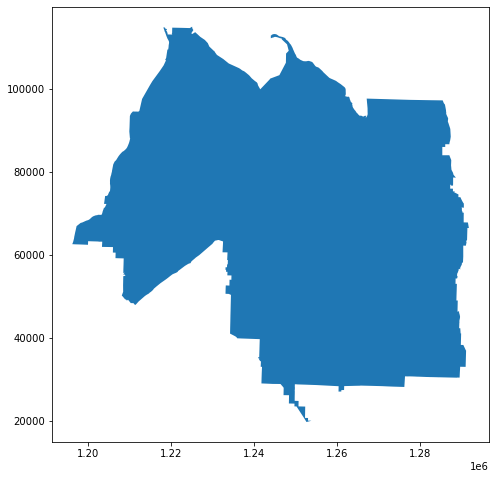

In [6]:
gdf_pm25.plot(figsize=(8,8))

In [7]:
# Load network shapefile to intersect network with conformity areas
gdf_network = gpd.read_file(r'../../../inputs/scenario/networks/shapefiles/AM/AM_edges.shp')

# Intersect network links with conformity geography
gdf_intersect = gpd.overlay(gdf_network, gdf_pm25, how="intersection")

In [8]:
# intesect conformity area with TAZ file to get list of TAZs for intrazonal calculations
taz_maint = gpd.overlay(gdf_pm25, taz_gdf, how="intersection")

In [9]:
# taz_maint

TAZs in Maintenance Area. The intrazonal emissions totals will be included for these TAZs

<AxesSubplot:>

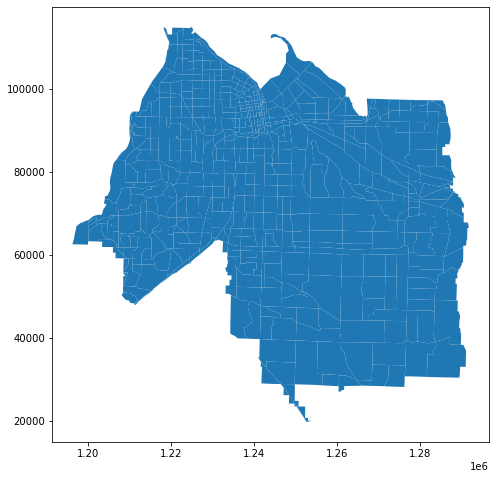

In [10]:
taz_maint.plot(figsize=(8,8))

Network within PM2.5 Maintenance Area.

These network links are used to calculate running (interzonal) emissions totals.

<AxesSubplot:>

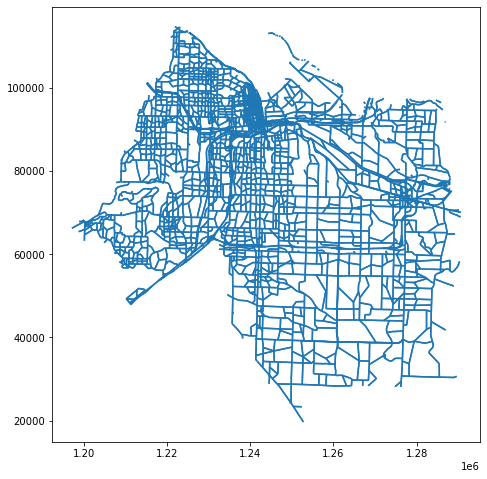

In [11]:
gdf_intersect.plot(figsize=(8,8))

In [12]:
# Load network results with data on VMT, speed, facility type, etc. 
network_df = pd.read_csv(r'../../../outputs/network/network_results.csv')

In [13]:
# Join network data to the PM2.5 maintenance area network
network_pm25_df = gdf_intersect[['id']].merge(network_df, left_on='id', right_on='ij')

In [14]:
# Create output subdirectory for conformity emissions results 
if not os.path.isdir('../../../outputs/emissions/conformity'):
    os.makedirs('../../../outputs/emissions/conformity')


In [15]:
conn = create_engine('sqlite:///../../../inputs/db/soundcast_inputs.db')

# Load running emission rates by vehicle type, for the model year
df_running_rates = pd.read_sql('SELECT * FROM running_emission_rates_by_veh_type WHERE year=='+model_year, con=conn)
df_running_rates.rename(columns={'ratePerDistance': 'grams_per_mile'}, inplace=True)
df_running_rates['year'] = df_running_rates['year'].astype('str')

# Select the month to use for each pollutant; some rates are used for winter or summer depending
# on when the impacts are at a maximum due to temperature.
df_summer = df_running_rates[df_running_rates['pollutantID'].isin(summer_list)]
df_summer = df_summer[df_summer['monthID'] == 7]
df_winter = df_running_rates[~df_running_rates['pollutantID'].isin(summer_list)]
df_winter = df_winter[df_winter['monthID'] == 1]
df_running_rates = df_winter.append(df_summer)

# Group interzonal trips and calculate interzonal emissions
df_interzonal_vmt = calculate_interzonal_vmt(network_pm25_df)
df_interzonal = calculate_interzonal_emissions(df_interzonal_vmt, df_running_rates)

In [16]:
# Calculate start emissions by vehicle type
start_emissions_df = calculate_start_emissions()

# Select only emissions for Pierce County, the location of the maintenance area
start_emissions_df = start_emissions_df[start_emissions_df['county'] == 'pierce']

# Start emissions are based on vehicles per county
# Since the PM Maintenance area is only a portion of Pierce County
# we need to apply a scaling factor to represent only the study area
# In previous analyses we used % VMT in the study area compared to Pierce County overall

# calculate total VMT in the maintenance area
network_pm25_df['VMT'] = network_pm25_df['@tveh']*network_pm25_df['length']
maint_vmt = network_pm25_df['VMT'].sum()

# Apply county names
county_id_lookup = {
    33: 'king',
    35: 'kitsap',
    53: 'pierce',
    61: 'snohomish'
}

# Calculate total VMT for pierce county
network_df['VMT'] = network_df['@tveh']*network_df['length']
network_df['county_name'] = network_df['@countyid'].map(county_id_lookup)
pierce_vmt = network_df[network_df['county_name'] == 'pierce']['VMT'].sum()

starts_scaling_factor = maint_vmt/pierce_vmt

# Apply scaling factor to the starts emissions totals
start_emissions_df['start_tons'] = start_emissions_df['start_tons']*starts_scaling_factor

In [17]:
# Group intrazonal trips and calculate intrazonal emissions
df_intrazonal_vmt = calculate_intrazonal_vmt()
df_intrazonal = calculate_intrazonal_emissions(df_running_rates)

# Combine all rates and export as CSV
df_inter_group = df_interzonal.groupby(['pollutantID','veh_type']).sum()[['tons_tot']].reset_index()
df_inter_group.rename(columns={'tons_tot': 'interzonal_tons'}, inplace=True)
df_intra_group = df_intrazonal.groupby(['pollutantID','veh_type']).sum()[['tons_tot']].reset_index()
df_intra_group.rename(columns={'tons_tot': 'intrazonal_tons'}, inplace=True)
df_start_group = start_emissions_df.groupby(['pollutantID','veh_type']).sum()[['start_tons']].reset_index()

summary_df = pd.merge(df_inter_group, df_intra_group)
summary_df = pd.merge(summary_df, df_start_group, how='left')
summary_df = finalize_emissions(summary_df, col_suffix="")
summary_df.loc[~summary_df['pollutantID'].isin(['PM','PM10','PM25']),'pollutantID'] = summary_df[~summary_df['pollutantID'].isin(['PM','PM10','PM25'])]['pollutantID'].astype('int')
summary_df['pollutant_name'] = summary_df['pollutantID'].astype('int', errors='ignore').astype('str').map(pollutant_map)
summary_df['total_daily_tons'] = summary_df['start_tons']+summary_df['interzonal_tons']+summary_df['intrazonal_tons']
summary_df = summary_df[['pollutantID','pollutant_name','veh_type','start_tons','intrazonal_tons','interzonal_tons','total_daily_tons']]
summary_df.to_csv(r'../../../outputs/emissions/conformity/emissions_summary.csv',index=False)

# PM2.5
Tons

In [18]:
df = summary_df[summary_df['pollutant_name'] == 'PM25 Total']
df = df[['veh_type','start_tons','intrazonal_tons','interzonal_tons','total_daily_tons']]
df.index = df['veh_type']
df[['start_tons','intrazonal_tons','total_daily_tons']]

,start_tons,intrazonal_tons,total_daily_tons
veh_type,,,
heavy,0.000028,0.000080,0.117693
light,0.051478,0.000928,0.188652
medium,0.008874,0.000005,0.024980


Pounds in Maintenance Area

In [19]:
df_lbs = df[['start_tons','intrazonal_tons','interzonal_tons','total_daily_tons']]*2000
df_lbs.rename(columns={'start_tons': 'start_pounds', 'intrazonal_tons': 'intrazonal_pounds', 
                       'total_daily_tons': 'total_daily_pounds', 'interzonal_tons': 'interzonal_pounds'}, inplace=True)

In [20]:
df_lbs

,start_pounds,intrazonal_pounds,interzonal_pounds,total_daily_pounds
veh_type,,,,
heavy,0.056788,0.160516,235.169218,235.386521
light,102.955497,1.855545,272.493731,377.304773
medium,17.747203,0.010525,32.201766,49.959493


Total Pounds in Mainentance Area

In [21]:
df_lbs['total_daily_pounds'].sum()

662.6507879518655

# NOx
Tons in Maintenance Area

In [22]:
df = summary_df[summary_df['pollutant_name'] == 'NOx']
df = df[['veh_type','start_tons','intrazonal_tons','interzonal_tons','total_daily_tons']]
df.index = df['veh_type']
df[['start_tons','intrazonal_tons','total_daily_tons']]

,start_tons,intrazonal_tons,total_daily_tons
veh_type,,,
heavy,0.002551,0.002172,3.864767
light,1.189943,0.023443,6.596775
medium,0.350849,0.000153,0.946611


Pounds in Maintenance Area

In [23]:
df_lbs = df[['start_tons','intrazonal_tons','interzonal_tons','total_daily_tons']]*2000
df_lbs.rename(columns={'start_tons': 'start_pounds', 'intrazonal_tons': 'intrazonal_pounds', 
                       'total_daily_tons': 'total_daily_pounds', 'interzonal_tons': 'interzonal_pounds'}, inplace=True)

In [24]:
df_lbs

,start_pounds,intrazonal_pounds,interzonal_pounds,total_daily_pounds
veh_type,,,,
heavy,5.101735,4.343610,7720.088052,7729.533397
light,2379.885264,46.886436,10766.777337,13193.549037
medium,701.698826,0.306645,1191.215972,1893.221442


Total Pounds in Maitenance Area

In [25]:
df_lbs['total_daily_pounds'].sum()

22816.303875835292